### Import libraries

In [6]:
# Import all libraries regarding torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde, lognorm
import os
from torch.utils.data import Dataset, DataLoader
import time
import shutil
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets

### Read Input data

In [7]:
# Reading from RSA_input.csv
df = pd.read_csv('RSA_input.csv') # add csv file to the correct location
grain_R = df["grain_R"]
grain_asp = df["grain_asp"]

# Combined into numpy shape (30218, 2)
grainsData = np.column_stack((grain_R, grain_asp))
print(f"grainsData shape: {grainsData.shape}")

exp_max_R = np.max(grainsData[:,0])
exp_min_R = np.min(grainsData[:,0])
exp_max_asp = np.max(grainsData[:,1])
exp_min_asp = np.min(grainsData[:,1])

print("[min, max] of exp_grain_R: [{}, {}]".format(exp_min_R, exp_max_R))
print("[min, max] of exp_grain_asp: [{}, {}]".format(exp_min_asp, exp_max_asp))

device = "cuda:0" if torch.cuda.is_available() else "cpu"

grainsData shape: (30218, 2)
[min, max] of exp_grain_R: [3.989422804, 108.8169461]
[min, max] of exp_grain_asp: [1.0, 6.209501941]


### Generator and Discriminator definition

In [8]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Generator
class Generator(nn.Module):
    def __init__(self, latent_Gaussian_dimension, number_of_grain_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_Gaussian_dimension, 75),
            nn.ReLU(),
            nn.Linear(75, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, number_of_grain_features)
        )

    def forward(self, x):
        return self.model(x)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, number_of_grain_features):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(number_of_grain_features, 25),
            nn.ReLU(),
            nn.Linear(25, 50),
            nn.ReLU(),
            nn.Linear(50, 75),
            nn.ReLU(),
            nn.Linear(75, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


def generator_loss(discriminator, fake_grains):
    """Loss computed to train the GAN generator.

    Args:
      discriminator: The discriminator whose forward function takes inputs of shape (batch_size, 2)
         and produces outputs of shape (batch_size, 1).
      fake_grains of shape (batch_size, 2): Fake grains produces by the generator.

    Returns:
      loss: The mean of the binary cross-entropy losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_grains.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # Ensure that the target tensor has the same device as the input fake_grains
    target = torch.full((fake_grains.size(0),), real_label, device=fake_grains.device)
    
    # Forward pass through the discriminator with the fake grains
    output = discriminator(fake_grains).view(-1)
    
    # Compute the binary cross-entropy loss between the output and the target
    loss = F.binary_cross_entropy(output, target, reduction='mean')
    
    return loss

def discriminator_loss(discriminator, real_grains, fake_grains):
    """Loss computed to train the GAN discriminator.

    Args:
      discriminator: The discriminator.
      real_grains of shape (batch_size, 2): Real grains.
      fake_grains of shape (batch_size, 2): Fake grains produces by the generator.

    Returns:
      d_loss_real: The mean of the binary cross-entropy losses computed on the real_grains.
      D_real: Mean output of the discriminator for real_grains. This is useful for tracking convergence.
      d_loss_fake: The mean of the binary cross-entropy losses computed on the fake_grains.
      D_fake: Mean output of the discriminator for fake_grains. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `fake_grains.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Ensure that the target tensors have the same device as the input grains
    device = fake_grains.device  # Get the device of the input tensors
    
    # Transfer input tensors to the same device as the discriminator
    real_grains = real_grains.to(device)
    fake_grains = fake_grains.to(device)
    
    # Create the target labels for real and fake grains
    real_target = torch.full((real_grains.size(0),), real_label, device=device)
    fake_target = torch.full((fake_grains.size(0),), fake_label, device=device)
    
    # Compute the discriminator outputs for real and fake grains
    real_output = discriminator(real_grains).view(-1)
    fake_output = discriminator(fake_grains).view(-1)
    
    # Compute the binary cross-entropy losses
    d_loss_real = nn.BCELoss()(real_output, real_target)
    d_loss_fake = nn.BCELoss()(fake_output, fake_target)
    
    # Compute the mean discriminator outputs for real and fake grains
    D_real = real_output.mean().item()
    D_fake = fake_output.mean().item()
    
    return d_loss_real, D_real, d_loss_fake, D_fake


### Testing shapes and loss value

In [9]:
# Test generator loss
def test_generator_loss():
    # Create a generator
    netG = Generator(latent_Gaussian_dimension=2, number_of_grain_features=2)
    netD = Discriminator(number_of_grain_features=2)
    # Create fake grains
    noise = torch.randn(100, 2)
    fake_grains = netG(noise)
    # Compute the generator loss
    loss = generator_loss(netD, fake_grains)
    print(loss)

test_generator_loss()

tensor(0.7423, grad_fn=<BinaryCrossEntropyBackward0>)


In [10]:
# Test discriminator loss
def test_discriminator_loss():
    # Create a generator
    netG = Generator(latent_Gaussian_dimension=2, number_of_grain_features=2)
    netD = Discriminator(number_of_grain_features=2)
    # Create real and fake grains
    real_grains = torch.randn(100, 2)
    noise = torch.randn(100, 2)
    fake_grains = netG(noise)
    # Compute the discriminator loss
    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_grains, fake_grains)
    print(d_loss_real)
    print(D_real)
    print(d_loss_fake)
    print(D_fake)

test_discriminator_loss()

tensor(0.7283, grad_fn=<BinaryCrossEntropyBackward0>)
0.48275160789489746
tensor(0.6599, grad_fn=<BinaryCrossEntropyBackward0>)
0.4831079840660095


In [11]:
def test_Generator_shapes():
    netG = Generator(100, 2)

    batch_size = 32
    noise = torch.randn(batch_size, 100)
    out = netG(noise)

    assert out.shape == torch.Size([batch_size, 2]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

Success


In [12]:
def test_Discriminator_shapes():
    netD = Discriminator(2)

    batch_size = 32
    noise = torch.randn(batch_size, 2)
    out = netD(noise)

    assert out.shape == torch.Size([batch_size, 1]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

Success


### Plotting generated data

In [13]:
def plot_data(epoch, grains):
    # Plot 2 subfigures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    fontsize = 10
    df = pd.read_csv('RSA_input.csv')
    exp_grain_R = df["grain_R"]
    exp_grain_asp = df["grain_asp"]

    generated_data = pd.read_csv(f'downsampled_grains_GAN/epoch_{epoch}/grains_{grains}.csv')
    generated_grain_R = generated_data["grain_R"]
    generated_grain_asp = generated_data["grain_asp"]

    # Plot scatterplot
    ax1.scatter(exp_grain_R, exp_grain_asp, alpha=0.5)
    ax1.set_title(f'Epoch {epoch}: Experimental \ngrain_R and grain_asp', fontsize=fontsize)
    ax1.set_xlabel('grain_R', fontsize=fontsize)
    ax1.set_ylabel('grain_asp', fontsize=fontsize)
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0.5, 7])

    # Plot scatterplot
    ax2.scatter(generated_grain_R, generated_grain_asp, alpha=0.5)
    ax2.set_title(f'Epoch {epoch}: GAN \ngrain_R and grain_asp', fontsize=fontsize)
    ax2.set_xlabel('grain_R', fontsize=fontsize)
    ax2.set_ylabel('grain_asp', fontsize=fontsize)
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0.5, 7])

    plt.show()

### Hyperparameters

In [14]:
weight_clipping_limit = 0.01
num_epochs = 10
printAndSaveEvery_N_Epoch = 1
latent_Gaussian_dimension = 100  # Dimension of the input noise vector
number_of_grain_features = 2  # Dimension of the real data
# real_data_dim = 30218  # Dimension of the real data
number_of_reduced_grains = 1000  # Dimension of the generated data

learning_rate = 5e-4
batch_size = 1000

[min, max] of exp_grain_R: [3.989422804, 108.8169461]
[min, max] of exp_grain_asp: [1.0, 6.209501941]


Epoch 0
Discriminator Loss: D_real=0.3543, D_fake=0.3557
Generator Loss: 0.5722
Number of generated grains lying inside experimental range: 0/20


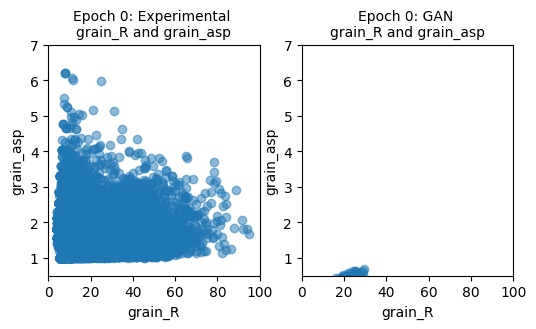

Epoch 1
Discriminator Loss: D_real=0.3940, D_fake=0.3969
Generator Loss: 0.8296
Number of generated grains lying inside experimental range: 0/20


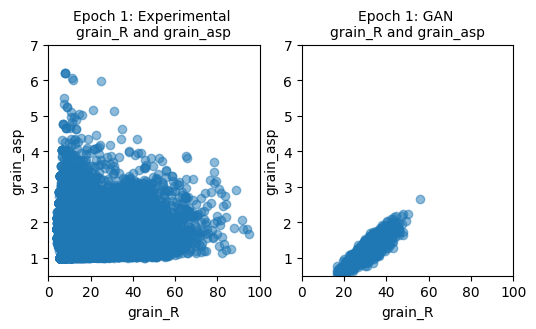

Epoch 2
Discriminator Loss: D_real=0.4495, D_fake=0.4254
Generator Loss: 0.7912
Number of generated grains lying inside experimental range: 0/20


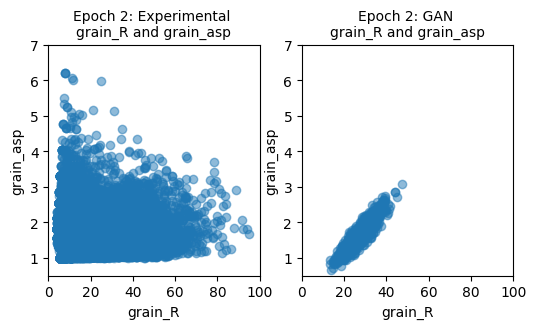

Epoch 3
Discriminator Loss: D_real=0.5129, D_fake=0.4717
Generator Loss: 0.7429
Number of generated grains lying inside experimental range: 0/20


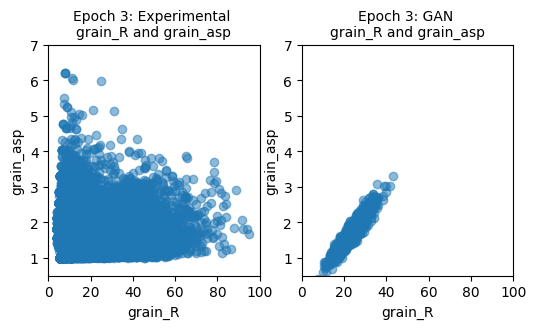

Epoch 4
Discriminator Loss: D_real=0.5373, D_fake=0.4849
Generator Loss: 0.8127
Number of generated grains lying inside experimental range: 0/20


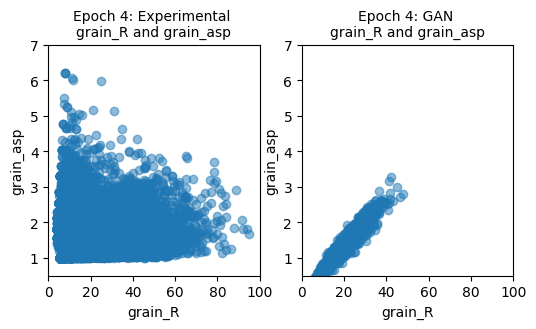

Epoch 5
Discriminator Loss: D_real=0.4575, D_fake=0.4197
Generator Loss: 0.5808
Number of generated grains lying inside experimental range: 0/20


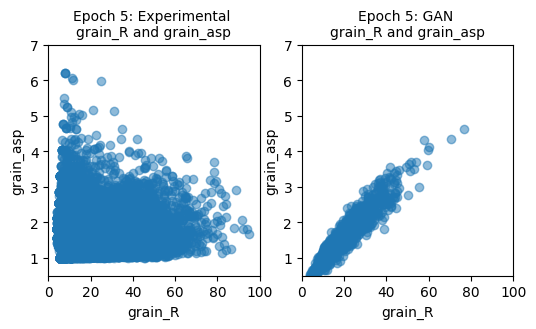

Epoch 6
Discriminator Loss: D_real=0.5014, D_fake=0.4981
Generator Loss: 0.7902
Number of generated grains lying inside experimental range: 0/20


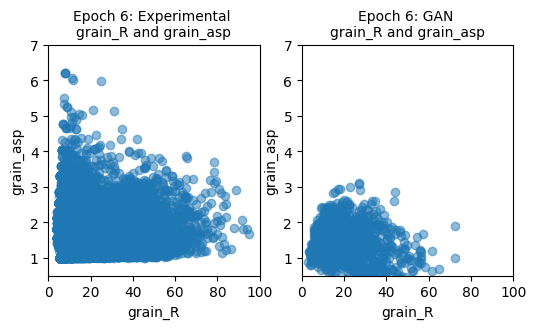

Epoch 7
Discriminator Loss: D_real=0.4851, D_fake=0.4864
Generator Loss: 0.7481
Number of generated grains lying inside experimental range: 0/20


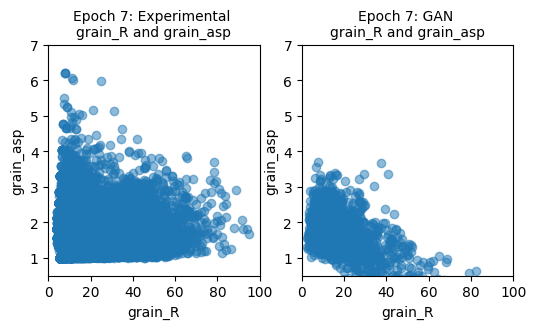

Epoch 8
Discriminator Loss: D_real=0.4785, D_fake=0.4777
Generator Loss: 0.6710
Number of generated grains lying inside experimental range: 0/20


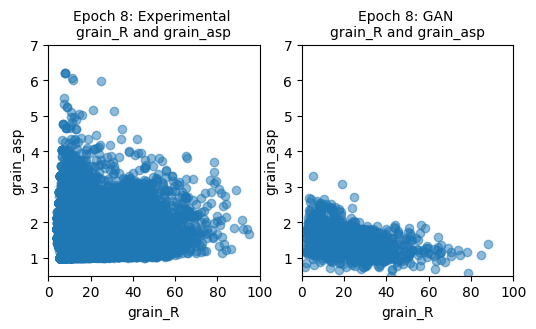

Epoch 9
Discriminator Loss: D_real=0.4952, D_fake=0.4905
Generator Loss: 0.6742
Number of generated grains lying inside experimental range: 0/20


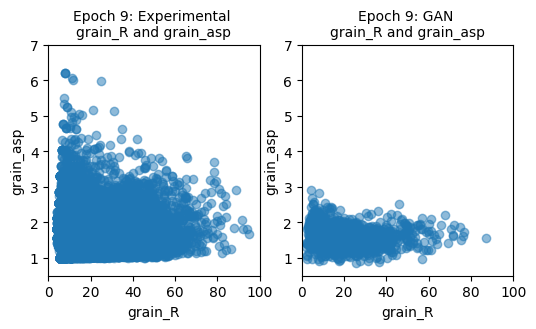

Epoch 10
Discriminator Loss: D_real=0.5185, D_fake=0.5157
Generator Loss: 0.7347
Number of generated grains lying inside experimental range: 0/20


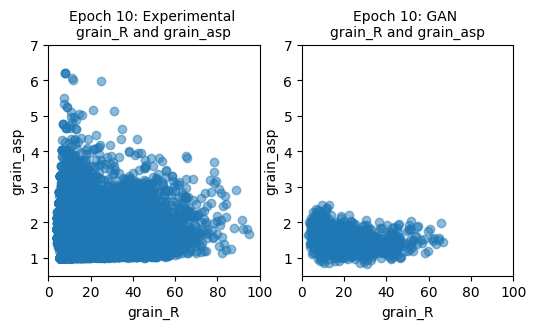

In [15]:
# initialize generator and discriminator net
generator_net = Generator(latent_Gaussian_dimension, number_of_grain_features).to(device)
discriminator_net = Discriminator(number_of_grain_features).to(device)

# Define optimizer. 

exp_max_R = np.max(grainsData[:,0])
exp_min_R = np.min(grainsData[:,0])
exp_max_asp = np.max(grainsData[:,1])
exp_min_asp = np.min(grainsData[:,1])

print("[min, max] of exp_grain_R: [{}, {}]".format(exp_min_R, exp_max_R))
print("[min, max] of exp_grain_asp: [{}, {}]".format(exp_min_asp, exp_max_asp))

# initialize generator and discriminator optimizer
# The paper mentions using RMSProp

generator_optimizer = optim.RMSprop(generator_net.parameters(), lr=learning_rate)
discriminator_optimizer = optim.RMSprop(discriminator_net.parameters(), lr=learning_rate)

# generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Create DataLoader
dataloader = DataLoader(grainsData, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs + 1):
    for batch_index, real_grains in enumerate(dataloader):
        real_grains = real_grains.to(torch.float32)
        batch_size_local = real_grains.shape[0]
        # real_grains is of shape (batch_size, number_of_grain_features)

        ################################
        # Update Discriminator network #
        ################################

        discriminator_net.zero_grad()

        noise = torch.randn(batch_size_local, latent_Gaussian_dimension, device=device, dtype=torch.float32)
        fake_grains = generator_net(noise)

        # Compute discriminator loss
        d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(discriminator_net, real_grains, fake_grains)
        d_loss = d_loss_real + d_loss_fake
        
        # Update discriminator
        d_loss.backward()
        discriminator_optimizer.step()
        
        ############################
        # Update Generator network
        ###########################
        generator_optimizer.zero_grad()
        
        # Generate fake grains
        noise = torch.randn(batch_size_local, latent_Gaussian_dimension, device=device)
        fake_grains = generator_net(noise)
        
        # Compute generator loss
        g_loss = generator_loss(discriminator_net, fake_grains)
        
        # Update generator
        g_loss.backward()
        generator_optimizer.step()
            
    ######################################
    # Print and saving training progress #
    ######################################

    if epoch % printAndSaveEvery_N_Epoch == 0:
        print("=====================================")
        print(f"Epoch {epoch}")
        print(f"Discriminator Loss: D_real={D_real:.4f}, D_fake={D_fake:.4f}")
        print(f"Generator Loss: {g_loss:.4f}")

    if epoch % printAndSaveEvery_N_Epoch == 0:
        with torch.no_grad():
            # Generate fake grains and save into csv file
            generate_times = 20
            # for each epoch, we wil generate 20 different groups of fake grains as generator is random
            outputPath = f"downsampled_grains_GAN/epoch_{epoch}"
            if os.path.exists(outputPath):
                # remove the directory if it exists and create new
                shutil.rmtree(outputPath)
                os.makedirs(outputPath)
            else:
                os.makedirs(outputPath)

            numberOfGeneratedGrainsLyingInsideExpRange = 0
            for i in range(generate_times):
                outputPathIndex = f"downsampled_grains_GAN/epoch_{epoch}"
                noise = torch.randn(number_of_reduced_grains, latent_Gaussian_dimension, device=device)

                fake_grains = generator_net(noise)
                fake_grains = fake_grains.cpu().numpy()
                # print(f"min, max grain_R: [{np.min(fake_grains[:, 0])}, {np.max(fake_grains[:, 0])}]")
                # print(f"min, max grain_asp: [{np.min(fake_grains[:, 1])}, {np.max(fake_grains[:, 1])}]")
                if np.min(fake_grains[:, 0]) >= exp_min_R and np.max(fake_grains[:, 0]) <= exp_max_R and np.min(fake_grains[:, 1]) >= exp_min_asp and np.max(fake_grains[:, 1]) <= exp_max_asp:
                    numberOfGeneratedGrainsLyingInsideExpRange += 1
                # print(fake_grains.shape)
                # Save as csv file, use pandas
                columns = ["grain_R", "grain_asp"]
                df = pd.DataFrame(fake_grains, columns=columns)
                df.to_csv(f"{outputPathIndex}/grains_{i+1}.csv", index=False)
            print(f"Number of generated grains lying inside experimental range: {numberOfGeneratedGrainsLyingInsideExpRange}/{generate_times}")
        plot_data(epoch, 1)
